# SKIN_TONE_DETECTOR

## IMPORT LIBRARY

In [17]:
import cv2
import allotSkinTone
import skin_detector
from sklearn.cluster import KMeans
import csv
from collections import defaultdict 
import matplotlib.pyplot as plt
import time
import logging
import cv2
import numpy
import os
from IPython.display import display, Image
import cv2
import numpy as np
import random

## SKIN DETECTOR

In [19]:
def find_images(path, recursive=False, ignore=True):
    if os.path.isfile(path):
        yield path
    elif os.path.isdir(path):
        assert os.path.isdir(path), 'FileIO - get_images: Directory does not exist'
        assert isinstance(recursive, bool), 'FileIO - get_images: recursive must be a boolean variable'
        ext, result = ['png', 'jpg', 'jpeg'], []
        for path_a in os.listdir(path):
            path_a = path + '/' + path_a
            if os.path.isdir(path_a) and recursive:
                for path_b in find_images(path_a):
                    yield path_b
            check_a = path_a.split('.')[-1] in ext
            check_b = ignore or ('-' not in path_a.split('/')[-1])
            if check_a and check_b:
                yield path_a
    else:
        raise ValueError('error! path is not a valid path or directory')


def display(title, img, max_size=200000):
    assert isinstance(img, numpy.ndarray), 'img must be a numpy array'
    assert isinstance(title, str), 'title must be a string'
    scale = numpy.sqrt(min(1.0, float(max_size) / (img.shape[0] * img.shape[1])))
    shape = (int(scale * img.shape[1]), int(scale * img.shape[0]))
    img = cv2.resize(img, shape)
    cv2.imshow(title, img)
    
    

logger = logging.getLogger('main')


def get_hsv_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting hsv mask')

    lower_thresh = numpy.array([0, 50, 0], dtype=numpy.uint8)
    upper_thresh = numpy.array([120, 150, 255], dtype=numpy.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    msk_hsv = cv2.inRange(img_hsv, lower_thresh, upper_thresh)

    msk_hsv[msk_hsv < 128] = 0
    msk_hsv[msk_hsv >= 128] = 1

    if debug:
        display('input', img)
        display('mask_hsv', msk_hsv)

    return msk_hsv.astype(float)


def get_rgb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting rgb mask')

    lower_thresh = numpy.array([45, 52, 108], dtype=numpy.uint8)
    upper_thresh = numpy.array([255, 255, 255], dtype=numpy.uint8)

    mask_a = cv2.inRange(img, lower_thresh, upper_thresh)
    mask_b = 255 * ((img[:, :, 2] - img[:, :, 1]) / 20)
    mask_c = 255 * ((numpy.max(img, axis=2) - numpy.min(img, axis=2)) / 20)
    # msk_rgb = cv2.bitwise_and(mask_c, cv2.bitwise_and(mask_a, mask_b))
    mask_d = numpy.bitwise_and(numpy.uint64(mask_a), numpy.uint64(mask_b))
    msk_rgb = numpy.bitwise_and(numpy.uint64(mask_c), numpy.uint64(mask_d))

    msk_rgb[msk_rgb < 128] = 0
    msk_rgb[msk_rgb >= 128] = 1

    if debug:
        display('input', img)
        display('mask_rgb', msk_rgb)

    return msk_rgb.astype(float)


def get_ycrcb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting ycrcb mask')

    lower_thresh = numpy.array([90, 100, 130], dtype=numpy.uint8)
    upper_thresh = numpy.array([230, 120, 180], dtype=numpy.uint8)

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    msk_ycrcb = cv2.inRange(img_ycrcb, lower_thresh, upper_thresh)

    msk_ycrcb[msk_ycrcb < 128] = 0
    msk_ycrcb[msk_ycrcb >= 128] = 1

    if debug:
        display('input', img)
        display('mask_ycrcb', msk_ycrcb)

    return msk_ycrcb.astype(float)


def grab_cut_mask(img_col, mask, debug=False):
    assert isinstance(img_col, numpy.ndarray), 'image must be a numpy array'
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert img_col.ndim == 3, 'skin detection can only work on color images'
    assert mask.ndim == 2, 'mask must be 2D'

    kernel = numpy.ones((50, 50), numpy.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = numpy.array(cv2.bitwise_not(dst), dtype=numpy.uint8)

    if debug:
        display('not skin', free)
        display('grabcut input', mask)

    grab_mask = numpy.zeros(mask.shape, dtype=numpy.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if numpy.unique(grab_mask).tolist() == [0, 1]:
        logger.debug('conducting grabcut')
        bgdModel = numpy.zeros((1, 65), numpy.float64)
        fgdModel = numpy.zeros((1, 65), numpy.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = numpy.where((mask == 2) | (mask == 0), 0, 1).astype(numpy.uint8)
        else:
            logger.warning('img_col is empty')

    return mask


def closing(mask):
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert mask.ndim == 2, 'mask must be a greyscale image'
    logger.debug("closing mask of shape {0}".format(mask.shape))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


def process(img, thresh=0.5, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug("processing image of shape {0}".format(img.shape))

    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)
    
    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks

    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
    logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * numpy.sum(mask) / mask.size)))

    mask = mask.astype(numpy.uint8)

    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    return mask
    

def show_skin_image(img, thresh=0.5, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug("processing image of shape {0}".format(img.shape))

    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)
    
    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks

    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
    logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * numpy.sum(mask) / mask.size)))

    mask = mask.astype(numpy.uint8)

    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    # Tạo ảnh mới với kích thước giống với ảnh đầu vào và màu trong suốt (đen hoặc màu alpha = 0)
    skin_image = numpy.zeros_like(img, dtype=numpy.uint8)

    # Cập nhật chỉ những phần có da từ ảnh gốc vào ảnh mới
    skin_image = cv2.bitwise_and(img, img, mask=mask)
    
    return skin_image
    

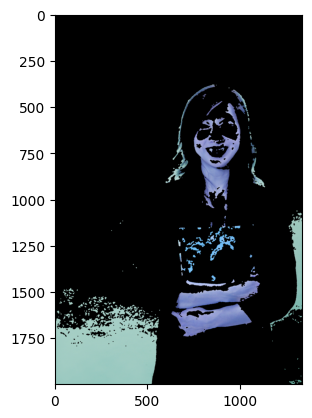

In [20]:
img_path = "359651.jpg"
image = cv2.imread(img_path)
skin_image = show_skin_image(image)

plt.imshow(skin_image)
plt.show()


## K-MEAN TO FIND DOMINANT COLOR

In [21]:
def create_map_from_csv(file_path):
    result_map = {}
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        for row in csv_reader:
            if len(row) >= 3:  # Đảm bảo có ít nhất 3 giá trị trên hàng
                key = row[0]
                value = row[-3]
                result_map[key] = value
                image_data.append(key)
    
    return result_map


csv_file_path = "D:\Code\BachKhoa\AI Hackathon\labels.csv"
image_data = []
label_map = create_map_from_csv(csv_file_path)
image_data = image_data[1:]
image_path = "D:\Code\BachKhoa\AI Hackathon\mnt\md0\projects\sami-hackathon\private\data"
count = 0
diffusion_matrix = defaultdict(lambda: defaultdict(lambda: 0))
random.shuffle(image_data)


In [22]:
def find_dominant_color(image, mask, n_colors=3):
    # Chuyển hình ảnh sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Dùng mặt nạ để lấy các vùng da trong hình ảnh
    skin_pixels = image_rgb[mask == 255]

    # Định hình lại skin_pixels thành một mảng 2D
    skin_pixels_2d = skin_pixels.reshape((-1, 3))

    # Áp dụng K-Means clustering
    kmeans = KMeans(n_clusters=n_colors, n_init=10)
    kmeans.fit(skin_pixels_2d)
    labels = kmeans.labels_
    
    # Đếm số lượng pixel cho mỗi cụm
    counts = np.bincount(labels)
    
    # Chọn cụm có số lượng pixel lớn nhất
    dominant_index = np.argmax(counts)
    
    # Lấy màu đặc trưng từ trung tâm cụm có số lượng pixel lớn nhất
    dominant_color = kmeans.cluster_centers_[dominant_index].astype(int)
    
    return dominant_color

def visualize_color(rgb_values):
    # Tạo một hình ảnh với một pixel màu RGB được chỉ định
    color_image = [[rgb_values]]

    # Hiển thị hình ảnh
    plt.imshow(color_image)
    plt.axis('off')
    plt.show()


start = time.time()
for img in image_data:
    print(img)
    img_link = image_path + "/" + img
    image = cv2.imread(img_link)
    # cv2.imshow("image", image)

    mask = skin_detector.process(image)
    if mask is not None:
        # Tìm màu đặc trưng
        dominant_color = find_dominant_color(image, mask)
        print(dominant_color)
                    
        # visualize_color(dominant_color)

        # Allot the actual skinTone to a certain shade
        allotedSkinToneVal = allotSkinTone.allotSkin(dominant_color)

        print(f"\033[91mImage: {img}. PREDICT: {allotedSkinToneVal}. LABEL: {label_map[img]}. COUNT: {count}\033[0m")
        diffusion_matrix[label_map[img]][allotedSkinToneVal]+=1
        
        
        count+=1
        if count==1000:
            break
    
    print(f"{'':<10}{'Dark':<10}{'Mid-Dark':<10}{'Mid-Light':<10}{'Light':<10}")
    print(f"{'Dark':<10}{diffusion_matrix['dark']['dark']:<10}{diffusion_matrix['dark']['mid-dark']:<10}{diffusion_matrix['dark']['mid-light']:<10}{diffusion_matrix['dark']['light']:<10}")
    print(f"{'Mid-Dark':<10}{diffusion_matrix['mid-dark']['dark']:<10}{diffusion_matrix['mid-dark']['mid-dark']:<10}{diffusion_matrix['mid-dark']['mid-light']:<10}{diffusion_matrix['mid-dark']['light']:<10}")
    print(f"{'Mid-Light':<10}{diffusion_matrix['mid-light']['dark']:<10}{diffusion_matrix['mid-light']['mid-dark']:<10}{diffusion_matrix['mid-light']['mid-light']:<10}{diffusion_matrix['mid-light']['light']:<10}")
    print(f"{'Light':<10}{diffusion_matrix['light']['dark']:<10}{diffusion_matrix['light']['mid-dark']:<10}{diffusion_matrix['light']['mid-light']:<10}{diffusion_matrix['light']['light']:<10}")
    print(f"Accuracy: {(diffusion_matrix['dark']['dark'] + diffusion_matrix['mid-dark']['mid-dark'] + diffusion_matrix['mid-light']['mid-light'] + diffusion_matrix['light']['light']) / count}")

finish = time.time()
print(f"Time: {finish - start}")

image_4780.jpg
[137 110  86]
Image: image_4780.jpg. PREDICT: mid-light. LABEL: mid-light. COUNT: 0
          Dark      Mid-Dark  Mid-Light Light     
Dark      0         0         0         0         
Mid-Dark  0         0         0         0         
Mid-Light 0         0         1         0         
Light     0         0         0         0         
Accuracy: 1.0
image_4794.jpg
[234 180 163]
Image: image_4794.jpg. PREDICT: light. LABEL: light. COUNT: 1
          Dark      Mid-Dark  Mid-Light Light     
Dark      0         0         0         0         
Mid-Dark  0         0         0         0         
Mid-Light 0         0         1         0         
Light     0         0         0         1         
Accuracy: 1.0
53829219.jpg
[158 133 118]
Image: 53829219.jpg. PREDICT: mid-light. LABEL: mid-light. COUNT: 2
          Dark      Mid-Dark  Mid-Light Light     
Dark      0         0         0         0         
Mid-Dark  0         0         0         0         
Mid-Light 0         0   